In [25]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [2]:
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git

fatal: destination path 'examples' already exists and is not an empty directory.


In [3]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
data_path = '/home/shellygoel2324/data_clean.csv'
labels_path = '/home/shellygoel2324/processedLabels.csv'

In [12]:
def load_pose_landmarks(csv_path, labels_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    labels = pd.read_csv(labels_path, header=None)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')

    # Extract the labels
    y = labels
    classes = range(8)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes, dataframe

In [13]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path, labels_path)
print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

(12819, 51) (12819, 8)


In [14]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(1,8):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(1,8):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION
1: 0.50931253047294
2: 0.24280838615309605
3: 0.11038517796196977
4: 0.04475865431496831
5: 0.02340321794246709
6: 0.008776206728425159
7: 0.060555826426133594

TEST DISTRIBUTION
1: 0.5195007800312013
2: 0.24726989079563183
3: 0.09750390015600624
4: 0.039781591263650544
5: 0.0358814352574103
6: 0.0062402496099844
7: 0.05382215288611544


In [15]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.87755768 0.41836466 0.1901963  0.07712023 0.0403243  0.01512161
 0.10433914]
[1.1395262382301, 2.390259253926029, 5.257725744059904, 12.966765887311135, 24.798939759482543, 66.13050602528679, 9.584131308012578]


In [19]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [21]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 17, 3)        0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 2)       0           ['reshape_1[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_9 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

 a)                                                                                               
                                                                                                  
 tf.math.multiply_12 (TFOpLambd  (None, 2)           0           ['tf.compat.v1.gather_12[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.broadcast_to_3 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_3[0][0]',       
                                                                  'tf.compat.v1.floor_div_3[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 2)           0           ['tf.math.multiply_13[0][0]',    
 mbda)    

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [26]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
628/641 [============================>.] - ETA: 0s - loss: 0.1951 - tp: 2675.0000 - fp: 233.0000 - tn: 70103.0000 - fn: 7373.0000 - accuracy: 0.9054 - precision: 0.9199 - recall: 0.2662 - auc: 0.9177 - prc: 0.7139
Epoch 1: val_loss improved from inf to 0.12350, saving model to weights.best.onlyfocalloss


2022-05-30 22:34:57.701328: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
641/641 [==============================] - 7s 7ms/step - loss: 0.1944 - tp: 2752.0000 - fp: 242.0000 - tn: 71543.0000 - fn: 7503.0000 - accuracy: 0.9056 - precision: 0.9192 - recall: 0.2684 - auc: 0.9181 - prc: 0.7156 - val_loss: 0.1235 - val_tp: 599.0000 - val_fp: 25.0000 - val_tn: 8949.0000 - val_fn: 683.0000 - val_accuracy: 0.9310 - val_precision: 0.9599 - val_recall: 0.4672 - val_auc: 0.9663 - val_prc: 0.8686
Epoch 2/200
629/641 [============================>.] - ETA: 0s - loss: 0.1471 - tp: 4248.0000 - fp: 319.0000 - tn: 70129.0000 - fn: 5816.0000 - accuracy: 0.9238 - precision: 0.9302 - recall: 0.4221 - auc: 0.9528 - prc: 0.8173
Epoch 2: val_loss improved from 0.12350 to 0.10931, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
641/641 [==============================] - 4s 7ms/step - loss: 0.1470 - tp: 4328.0000 - fp: 325.0000 - tn: 71460.0000 - fn: 

Epoch 12/200
622/641 [============================>.] - ETA: 0s - loss: 0.1053 - tp: 6095.0000 - fp: 392.0000 - tn: 69272.0000 - fn: 3857.0000 - accuracy: 0.9466 - precision: 0.9396 - recall: 0.6124 - auc: 0.9764 - prc: 0.8928
Epoch 12: val_loss did not improve from 0.07955
641/641 [==============================] - 2s 3ms/step - loss: 0.1055 - tp: 6287.0000 - fp: 408.0000 - tn: 71377.0000 - fn: 3968.0000 - accuracy: 0.9467 - precision: 0.9391 - recall: 0.6131 - auc: 0.9764 - prc: 0.8924 - val_loss: 0.0796 - val_tp: 855.0000 - val_fp: 30.0000 - val_tn: 8944.0000 - val_fn: 427.0000 - val_accuracy: 0.9554 - val_precision: 0.9661 - val_recall: 0.6669 - val_auc: 0.9866 - val_prc: 0.9383
Epoch 13/200
628/641 [============================>.] - ETA: 0s - loss: 0.1011 - tp: 6266.0000 - fp: 367.0000 - tn: 69969.0000 - fn: 3782.0000 - accuracy: 0.9484 - precision: 0.9447 - recall: 0.6236 - auc: 0.9783 - prc: 0.8997
Epoch 13: val_loss improved from 0.07955 to 0.07605, saving model to weights.best

Epoch 23/200
635/641 [============================>.] - ETA: 0s - loss: 0.0893 - tp: 6841.0000 - fp: 376.0000 - tn: 70744.0000 - fn: 3319.0000 - accuracy: 0.9545 - precision: 0.9479 - recall: 0.6733 - auc: 0.9830 - prc: 0.9189
Epoch 23: val_loss improved from 0.06906 to 0.06761, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
641/641 [==============================] - 4s 7ms/step - loss: 0.0895 - tp: 6906.0000 - fp: 381.0000 - tn: 71404.0000 - fn: 3349.0000 - accuracy: 0.9545 - precision: 0.9477 - recall: 0.6734 - auc: 0.9829 - prc: 0.9185 - val_loss: 0.0676 - val_tp: 949.0000 - val_fp: 39.0000 - val_tn: 8935.0000 - val_fn: 333.0000 - val_accuracy: 0.9637 - val_precision: 0.9605 - val_recall: 0.7402 - val_auc: 0.9898 - val_prc: 0.9534
Epoch 24/200
635/641 [============================>.] - ETA: 0s - loss: 0.0903 - tp: 6837.0000 - fp: 403.0000 - tn: 70717.0000 - fn: 3323.0000 - accuracy: 0.9542 - precision: 0.9443 - recall:

Epoch 34/200
639/641 [============================>.] - ETA: 0s - loss: 0.0845 - tp: 7075.0000 - fp: 379.0000 - tn: 71189.0000 - fn: 3149.0000 - accuracy: 0.9569 - precision: 0.9492 - recall: 0.6920 - auc: 0.9847 - prc: 0.9272
Epoch 34: val_loss did not improve from 0.06311
641/641 [==============================] - 2s 3ms/step - loss: 0.0845 - tp: 7100.0000 - fp: 381.0000 - tn: 71404.0000 - fn: 3155.0000 - accuracy: 0.9569 - precision: 0.9491 - recall: 0.6923 - auc: 0.9847 - prc: 0.9272 - val_loss: 0.0643 - val_tp: 968.0000 - val_fp: 43.0000 - val_tn: 8931.0000 - val_fn: 314.0000 - val_accuracy: 0.9652 - val_precision: 0.9575 - val_recall: 0.7551 - val_auc: 0.9909 - val_prc: 0.9561
Epoch 35/200
641/641 [==============================] - ETA: 0s - loss: 0.0840 - tp: 7157.0000 - fp: 376.0000 - tn: 71409.0000 - fn: 3098.0000 - accuracy: 0.9577 - precision: 0.9501 - recall: 0.6979 - auc: 0.9850 - prc: 0.9278
Epoch 35: val_loss improved from 0.06311 to 0.06252, saving model to weights.best

Epoch 45/200
640/641 [============================>.] - ETA: 0s - loss: 0.0810 - tp: 7255.0000 - fp: 404.0000 - tn: 71276.0000 - fn: 2985.0000 - accuracy: 0.9586 - precision: 0.9473 - recall: 0.7085 - auc: 0.9861 - prc: 0.9317
Epoch 45: val_loss did not improve from 0.05885
641/641 [==============================] - 2s 3ms/step - loss: 0.0810 - tp: 7265.0000 - fp: 404.0000 - tn: 71381.0000 - fn: 2990.0000 - accuracy: 0.9586 - precision: 0.9473 - recall: 0.7084 - auc: 0.9860 - prc: 0.9316 - val_loss: 0.0603 - val_tp: 977.0000 - val_fp: 31.0000 - val_tn: 8943.0000 - val_fn: 305.0000 - val_accuracy: 0.9672 - val_precision: 0.9692 - val_recall: 0.7621 - val_auc: 0.9918 - val_prc: 0.9622
Epoch 46/200
624/641 [============================>.] - ETA: 0s - loss: 0.0803 - tp: 7112.0000 - fp: 370.0000 - tn: 69518.0000 - fn: 2872.0000 - accuracy: 0.9594 - precision: 0.9505 - recall: 0.7123 - auc: 0.9866 - prc: 0.9329
Epoch 46: val_loss did not improve from 0.05885
641/641 [========================

641/641 [==============================] - 2s 3ms/step - loss: 0.0782 - tp: 7402.0000 - fp: 362.0000 - tn: 71423.0000 - fn: 2853.0000 - accuracy: 0.9608 - precision: 0.9534 - recall: 0.7218 - auc: 0.9871 - prc: 0.9368 - val_loss: 0.0581 - val_tp: 996.0000 - val_fp: 39.0000 - val_tn: 8935.0000 - val_fn: 286.0000 - val_accuracy: 0.9683 - val_precision: 0.9623 - val_recall: 0.7769 - val_auc: 0.9924 - val_prc: 0.9642
Epoch 57/200
639/641 [============================>.] - ETA: 0s - loss: 0.0775 - tp: 7369.0000 - fp: 379.0000 - tn: 71189.0000 - fn: 2855.0000 - accuracy: 0.9605 - precision: 0.9511 - recall: 0.7208 - auc: 0.9873 - prc: 0.9371
Epoch 57: val_loss improved from 0.05678 to 0.05582, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
641/641 [==============================] - 4s 6ms/step - loss: 0.0776 - tp: 7391.0000 - fp: 381.0000 - tn: 71404.0000 - fn: 2864.0000 - accuracy: 0.9604 - precision: 0.9510 - recall: 0.7207 -

Epoch 68/200
625/641 [============================>.] - ETA: 0s - loss: 0.0763 - tp: 7295.0000 - fp: 373.0000 - tn: 69627.0000 - fn: 2705.0000 - accuracy: 0.9615 - precision: 0.9514 - recall: 0.7295 - auc: 0.9880 - prc: 0.9388
Epoch 68: val_loss did not improve from 0.05493
641/641 [==============================] - 2s 3ms/step - loss: 0.0766 - tp: 7472.0000 - fp: 383.0000 - tn: 71402.0000 - fn: 2783.0000 - accuracy: 0.9614 - precision: 0.9512 - recall: 0.7286 - auc: 0.9879 - prc: 0.9383 - val_loss: 0.0550 - val_tp: 999.0000 - val_fp: 28.0000 - val_tn: 8946.0000 - val_fn: 283.0000 - val_accuracy: 0.9697 - val_precision: 0.9727 - val_recall: 0.7793 - val_auc: 0.9932 - val_prc: 0.9678
Epoch 69/200
630/641 [============================>.] - ETA: 0s - loss: 0.0765 - tp: 7315.0000 - fp: 363.0000 - tn: 70197.0000 - fn: 2765.0000 - accuracy: 0.9612 - precision: 0.9527 - recall: 0.7257 - auc: 0.9878 - prc: 0.9383
Epoch 69: val_loss did not improve from 0.05493
641/641 [========================

Epoch 80/200
636/641 [============================>.] - ETA: 0s - loss: 0.0739 - tp: 7521.0000 - fp: 358.0000 - tn: 70874.0000 - fn: 2655.0000 - accuracy: 0.9630 - precision: 0.9546 - recall: 0.7391 - auc: 0.9884 - prc: 0.9426
Epoch 80: val_loss did not improve from 0.05327
641/641 [==============================] - 2s 3ms/step - loss: 0.0737 - tp: 7588.0000 - fp: 359.0000 - tn: 71426.0000 - fn: 2667.0000 - accuracy: 0.9631 - precision: 0.9548 - recall: 0.7399 - auc: 0.9885 - prc: 0.9429 - val_loss: 0.0554 - val_tp: 1004.0000 - val_fp: 32.0000 - val_tn: 8942.0000 - val_fn: 278.0000 - val_accuracy: 0.9698 - val_precision: 0.9691 - val_recall: 0.7832 - val_auc: 0.9932 - val_prc: 0.9669
Epoch 81/200
630/641 [============================>.] - ETA: 0s - loss: 0.0740 - tp: 7349.0000 - fp: 363.0000 - tn: 70197.0000 - fn: 2731.0000 - accuracy: 0.9616 - precision: 0.9529 - recall: 0.7291 - auc: 0.9888 - prc: 0.9421
Epoch 81: val_loss did not improve from 0.05327
641/641 [=======================

Epoch 92/200
626/641 [============================>.] - ETA: 0s - loss: 0.0744 - tp: 7353.0000 - fp: 363.0000 - tn: 69749.0000 - fn: 2663.0000 - accuracy: 0.9622 - precision: 0.9530 - recall: 0.7341 - auc: 0.9885 - prc: 0.9422
Epoch 92: val_loss did not improve from 0.05274
641/641 [==============================] - 2s 3ms/step - loss: 0.0744 - tp: 7527.0000 - fp: 374.0000 - tn: 71411.0000 - fn: 2728.0000 - accuracy: 0.9622 - precision: 0.9527 - recall: 0.7340 - auc: 0.9885 - prc: 0.9422 - val_loss: 0.0567 - val_tp: 1019.0000 - val_fp: 33.0000 - val_tn: 8941.0000 - val_fn: 263.0000 - val_accuracy: 0.9711 - val_precision: 0.9686 - val_recall: 0.7949 - val_auc: 0.9927 - val_prc: 0.9651
Epoch 93/200
622/641 [============================>.] - ETA: 0s - loss: 0.0726 - tp: 7432.0000 - fp: 369.0000 - tn: 69295.0000 - fn: 2520.0000 - accuracy: 0.9637 - precision: 0.9527 - recall: 0.7468 - auc: 0.9889 - prc: 0.9443
Epoch 93: val_loss did not improve from 0.05274
641/641 [=======================

Epoch 104/200
628/641 [============================>.] - ETA: 0s - loss: 0.0728 - tp: 7497.0000 - fp: 371.0000 - tn: 69965.0000 - fn: 2551.0000 - accuracy: 0.9636 - precision: 0.9528 - recall: 0.7461 - auc: 0.9890 - prc: 0.9441
Epoch 104: val_loss improved from 0.05189 to 0.05133, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
641/641 [==============================] - 3s 5ms/step - loss: 0.0728 - tp: 7650.0000 - fp: 379.0000 - tn: 71406.0000 - fn: 2605.0000 - accuracy: 0.9636 - precision: 0.9528 - recall: 0.7460 - auc: 0.9889 - prc: 0.9440 - val_loss: 0.0513 - val_tp: 1042.0000 - val_fp: 39.0000 - val_tn: 8935.0000 - val_fn: 240.0000 - val_accuracy: 0.9728 - val_precision: 0.9639 - val_recall: 0.8128 - val_auc: 0.9938 - val_prc: 0.9711
Epoch 105/200
626/641 [============================>.] - ETA: 0s - loss: 0.0695 - tp: 7526.0000 - fp: 365.0000 - tn: 69747.0000 - fn: 2490.0000 - accuracy: 0.9644 - precision: 0.9537 - rec

Epoch 116/200
622/641 [============================>.] - ETA: 0s - loss: 0.0702 - tp: 7483.0000 - fp: 364.0000 - tn: 69300.0000 - fn: 2469.0000 - accuracy: 0.9644 - precision: 0.9536 - recall: 0.7519 - auc: 0.9898 - prc: 0.9480
Epoch 116: val_loss improved from 0.05133 to 0.04948, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
641/641 [==============================] - 3s 5ms/step - loss: 0.0703 - tp: 7720.0000 - fp: 375.0000 - tn: 71410.0000 - fn: 2535.0000 - accuracy: 0.9645 - precision: 0.9537 - recall: 0.7528 - auc: 0.9897 - prc: 0.9480 - val_loss: 0.0495 - val_tp: 1051.0000 - val_fp: 27.0000 - val_tn: 8947.0000 - val_fn: 231.0000 - val_accuracy: 0.9748 - val_precision: 0.9750 - val_recall: 0.8198 - val_auc: 0.9941 - val_prc: 0.9733
Epoch 117/200
627/641 [============================>.] - ETA: 0s - loss: 0.0716 - tp: 7537.0000 - fp: 357.0000 - tn: 69867.0000 - fn: 2495.0000 - accuracy: 0.9645 - precision: 0.9548 - rec

Epoch 128/200
631/641 [============================>.] - ETA: 0s - loss: 0.0695 - tp: 7583.0000 - fp: 356.0000 - tn: 70316.0000 - fn: 2513.0000 - accuracy: 0.9645 - precision: 0.9552 - recall: 0.7511 - auc: 0.9900 - prc: 0.9486
Epoch 128: val_loss did not improve from 0.04948
641/641 [==============================] - 2s 3ms/step - loss: 0.0696 - tp: 7705.0000 - fp: 360.0000 - tn: 71425.0000 - fn: 2550.0000 - accuracy: 0.9645 - precision: 0.9554 - recall: 0.7513 - auc: 0.9900 - prc: 0.9487 - val_loss: 0.0512 - val_tp: 1038.0000 - val_fp: 26.0000 - val_tn: 8948.0000 - val_fn: 244.0000 - val_accuracy: 0.9737 - val_precision: 0.9756 - val_recall: 0.8097 - val_auc: 0.9937 - val_prc: 0.9717
Epoch 129/200
622/641 [============================>.] - ETA: 0s - loss: 0.0708 - tp: 7488.0000 - fp: 362.0000 - tn: 69302.0000 - fn: 2464.0000 - accuracy: 0.9645 - precision: 0.9539 - recall: 0.7524 - auc: 0.9896 - prc: 0.9468
Epoch 129: val_loss did not improve from 0.04948
641/641 [===================

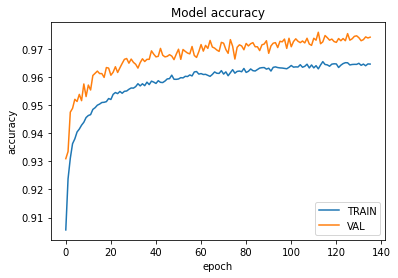

In [29]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

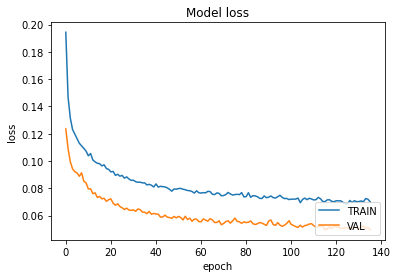

In [30]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [32]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.1256 - tp: 610.0000 - fp: 35.0000 - tn: 8939.0000 - fn: 672.0000 - accuracy: 0.9311 - precision: 0.9457 - recall: 0.4758 - auc: 0.9655 - prc: 0.8576


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.79      0.87       666
           2       0.68      0.86      0.76       317
           3       0.55      0.90      0.69       125
           4       0.55      0.35      0.43        51
           5       0.76      0.41      0.54        46
           6       0.29      1.00      0.44         8
           7       0.57      0.43      0.49        69

    accuracy                           0.77      1282
   macro avg       0.62      0.68      0.60      1282
weighted avg       0.81      0.77      0.77      1282



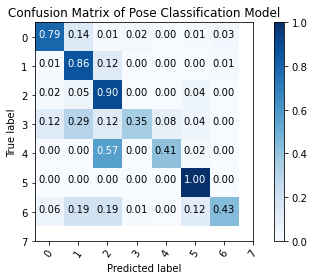

In [34]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))